In [11]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import warnings
warnings.filterwarnings("ignore")
from sklearn import metrics
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, classification_report, roc_curve
from sklearn.model_selection import RandomizedSearchCV
import numpy as np
from sklearn.metrics import roc_auc_score


# Get Data & Split into initial sets

No need to standardise as not sensitive to magnitude, as it is not a distance based algorithm and instead uses trees. So we can now split into test and train sets. Remove Area and Perimeter as they are very correlated, due to being function of radius.

In [12]:
df = pd.read_csv('./Data Exploration/wdbc.csv')
df = df.drop(["Area", "AreaSE", "AreaWorst", "Perimeter", "PerimeterSE", "PerimeterWorst"], axis = 1)
encoder = LabelEncoder().fit(df["B/M"])
df['B/M'] = encoder.transform(df["B/M"])
not_data = ["ID", "B/M"]
label = df["B/M"]
feature = df.drop(not_data, axis = 1)
data = pd.concat([label, feature], axis=1)

In [13]:
x_train, x_test, y_train, y_test = train_test_split(feature, label, test_size=0.20, stratify=label)

# Create & Train Model

Our initial model that we train, before hyperparameter tuning. We want a higher Recall, as it accounts for false negatives - and gives us a lower proportion of them, which we desire. We get a very high accuracy and recall and precision - which makes me suspect of overfitting, especially because we have such a small sample size respective to the number of features.

In [14]:
rfc = RandomForestClassifier(random_state=0, n_estimators=10)
rfc.fit(x_train, y_train)
y_pred = rfc.predict(x_test)

def bench_marks(y_test, y_pred):
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))
    print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
    print(f'Recall: {recall_score(y_test, y_pred)}')
    print(f'Precision: {precision_score(y_test, y_pred)}')

bench_marks(y_test, y_pred)

              precision    recall  f1-score   support

           0       0.96      0.99      0.97        72
           1       0.97      0.93      0.95        42

    accuracy                           0.96       114
   macro avg       0.97      0.96      0.96       114
weighted avg       0.97      0.96      0.96       114

[[71  1]
 [ 3 39]]
Accuracy: 0.9649122807017544
Recall: 0.9285714285714286
Precision: 0.975


# Feature Selection
One 'feature' of Random Forest Classification is we can get the importance of each figure in the category - which can help us get rid of features with low utility and also make inferences from our results. We will remove our the lowest importance features using our importance series and recreate our train test sets.

In [15]:
feature_scores = pd.Series(rfc.feature_importances_, index=x_train.columns).sort_values(ascending=False)
feature_scores = feature_scores.index.tolist()
important_features = feature_scores[:-20]
feature = df[important_features]
x_train, x_test, y_train, y_test = train_test_split(feature, label, test_size=0.20, stratify=label)

print(feature_scores)
print("\n")
print(important_features)

['RadiusWorst', 'Concavity', 'ConcavePointsWorst', 'Compactness', 'Radius', 'ConcavityWorst', 'RadiusSE', 'CompactnessWorst', 'FractalDimension', 'SymmetryWorst', 'ConcavePoints', 'FractalDimensionSE', 'CompactnessSE', 'TextureWorst', 'ConcavitySE', 'SmoothnessWorst', 'Texture', 'TextureSE', 'Smoothness', 'ConcavePointsSE', 'SmoothnessSE', 'FractalDimensionWorst', 'Symmetry', 'SymmetrySE']


['RadiusWorst', 'Concavity', 'ConcavePointsWorst', 'Compactness']


We remove our features, and try our metrics again. We get a higher precision if we remove the least important features? Why is this happening? It also loses some accuracy. This makes me suspect of overfitting.

In [16]:
rfc = RandomForestClassifier(random_state=0, n_estimators=100)
rfc.fit(x_train, y_train)
y_pred = rfc.predict(x_test)

bench_marks(y_test, y_pred)
feature_scores = pd.Series(rfc.feature_importances_, index=x_train.columns).sort_values(ascending=False)



              precision    recall  f1-score   support

           0       0.97      0.93      0.95        72
           1       0.89      0.95      0.92        42

    accuracy                           0.94       114
   macro avg       0.93      0.94      0.93       114
weighted avg       0.94      0.94      0.94       114

[[67  5]
 [ 2 40]]
Accuracy: 0.9385964912280702
Recall: 0.9523809523809523
Precision: 0.8888888888888888


# Hyperparameter Tuning

We will use a random grib with a randomized search to try different iterations of the trees and brute force our way to a optimal solution. We will repeat the code below, adjusting the parameters each iteration.

In [7]:
n_estimators = [int(x) for x in range(10,100,1)]
max_depth = [int(x) for x in np.linspace(20, 150, num = 5)]
max_depth.append(None)
max_features = ['sqrt']
min_samples_split = [2, 3, 4, 5, 7, 10]
min_samples_leaf = [1, 2, 3, 4]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [8]:
rf_random = RandomizedSearchCV(estimator = rfc, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(x_train, y_train)
rfc = rf_random.best_estimator_
y_pred = rfc.predict(x_test)
print(rf_random.best_estimator_)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')
print(f'Recall: {recall_score(y_test, y_pred)}')
print(f'Precision: {precision_score(y_test, y_pred)}')

Fitting 5 folds for each of 100 candidates, totalling 500 fits
RandomForestClassifier(bootstrap=False, max_depth=52, min_samples_leaf=4,
                       min_samples_split=3, n_estimators=30, random_state=0)
Accuracy: 0.956140350877193
Recall: 0.9523809523809523
Precision: 0.9302325581395349


We will reduce the number of n_estimators (the number of trees in the forest) , as increasing them while reducing overfitting would increase our precision at the cost of our recall. Min_samples_leaf cannot be too small, as this will increase overfitting.

# Test for over/ underfitting



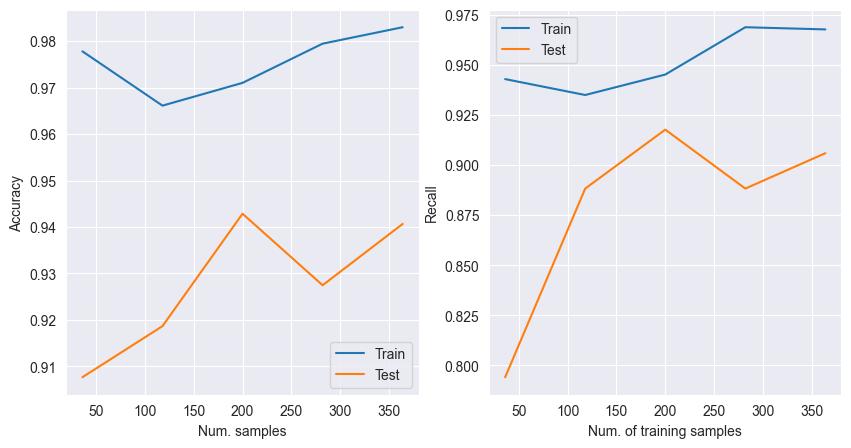

In [9]:
train_sizes_abs_accuracy, train_accuracy, test_accuracy = learning_curve(estimator=rfc, X=x_train, y=y_train, scoring='accuracy', cv=5)

train_sizes_abs_error, train_error, test_error = learning_curve(estimator=rfc, X=x_train, y=y_train, scoring='recall', cv=5)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
# Array of tuples (train_size, train_score)
train_avg_accuracy, test_avg_accuracy, train_avg_error, test_avg_error = [], [], [], []

for i in range(len(train_sizes_abs_accuracy)):
    train_avg_accuracy.append(np.average(train_accuracy[i]))
    test_avg_accuracy.append(np.average(test_accuracy[i]))

for i in range(len(train_sizes_abs_error)):
    train_avg_error.append(np.average(train_error[i]))
    test_avg_error.append(np.average(test_error[i]))

# Accuracy learning curve
ax[0].plot(train_sizes_abs_accuracy, train_avg_accuracy)
ax[0].plot(train_sizes_abs_accuracy, test_avg_accuracy)
ax[0].legend(['Train', 'Test'])
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Num. samples')

# Error learning curve
ax[1].plot(train_sizes_abs_error, train_avg_error)
ax[1].plot(train_sizes_abs_error, test_avg_error)
ax[1].legend(['Train', 'Test'])
ax[1].set_xlabel('Num. of training samples')
ax[1].set_ylabel('Recall')
plt.show()

100% accuracy and not changing with the number of samples is clearly overfitting, so we will manually remove the least significant variables we calculated to simplify our model - so that we can make up for our lack of instances. When writing up this report, we can do these graphs twice - once with many variable and second with few. We get a higher recall, even though we get a lower precision and accuracy when we use less variables. #When writing up explain why each one

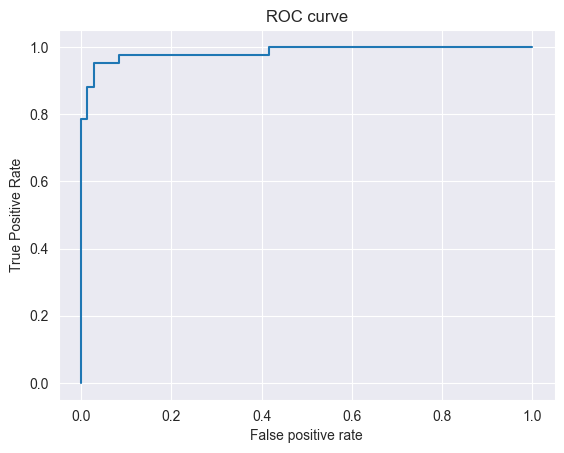

In [10]:
# After hyperparameter tuning* and feature selection*
auc = roc_auc_score(y_test, y_pred)



y_pred_prob = rfc.predict_proba(x_test)

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob[:, 1])
plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('False positive rate')
plt.ylabel('True Positive Rate')
plt.show()


We want to minimise false positives..

How does this graph help us? IG I could manually calculate (using the graph) the precesion, accuracy and  recall stats to determine which point is best.